# ボケ判定AIを作ろう！-チュートリアル1
このnotebookは、Nishikaコンペティション [ボケ判定AIを作ろう！](https://www.nishika.com/competitions/) のチュートリアルです。

「ボケて」データを用いて、画像データと文章からそのボケてが面白いか面白くないかを予測することをテーマとしています。

このNotebookでは、画像とテキストそれぞれの特徴量生成を以下のような方法で行っていきます。

- CNNモデルを用いた画像データの特徴量化
- BERTモデルを用いたテキストデータの特徴量化

特徴量の作成では、テキストと画像それぞれ別々で作成していますので、画像データとテキストデータを組み合わせた特徴量を入れることで精度向上が見込めるかも知れませんので、いろいろと試していただければと思います。

| 要素 | 説明 |
| ---- | ---- |
|id | ID|
|odai_photo_file_name | ボケてのお題画像|
|text | ボケての文章|
|is_laugh | 面白さ（面白い：１、面白くない：０）|


ディレクトリ構成は以下のように設定します

```
├── train.zip
│ ├── xxx.jpg
│ └── yyy.jpg
├── test.zip
│ ├── xxx.jpg
│ └── yyy.jpg
├── train.csv
├── test.csv
├── sample_submission.csv
└── submission.csv(今回のbaselineで生成されるsubmissionファイル)


```

### setting
ページ上部の「ランタイム」>「ランタイムのタイプを変更」から「GPU」「ハイメモリ」を選択

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Wed Sep 21 01:47:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    35W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Library

In [ ]:
!pip install --quiet transformers==4.18.0
!pip install --quiet tokenizers==0.12.1
!pip install --quiet sentencepiece
!pip install --quiet japanize-matplotlib
!pip install transformers fugashi ipadic >> /dev/null

In [ ]:
! pip install git+https://github.com/rinnakk/japanese-clip.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rinnakk/japanese-clip.git to /tmp/pip-req-build-8ocwobdz
  Running command git clone -q https://github.com/rinnakk/japanese-clip.git /tmp/pip-req-build-8ocwobdz


In [ ]:
! conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hnbt_iuy
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-hnbt_iuy


In [ ]:
! conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-cgxwx943
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-cgxwx943


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import transformers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb

from pathlib import Path

import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

import japanese_clip as ja_clip
from torchvision.io import read_image

import cv2

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Setting

In [ ]:
#上限表示数を拡張
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)

In [ ]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)

In [ ]:
INPUT = "/content/drive/MyDrive/nishika" # 所望のディレクトリに変更してください。
train_image_path ="/content/drive/MyDrive/nishika/train/"
test_image_path ="/content/drive/MyDrive/nishika/test/"

In [ ]:
train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))
submission_df = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))

train_df["img_path"] = train_image_path + train_df["odai_photo_file_name"]
test_df["img_path"] = test_image_path + test_df["odai_photo_file_name"]

In [ ]:
import torchvision.models as models


from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#import clip

model, preprocess = ja_clip.load("rinna/japanese-clip-vit-b-16", cache_dir="/tmp/japanese_clip", device=device)
tokenizer = ja_clip.load_tokenizer()

In [ ]:
def _get_img_paths(img_dir):
    img_dir = Path(img_dir)
    img_extensions = [".jpg"]
    img_paths = [str(p) for p in img_dir.iterdir() if p.suffix in img_extensions]
    img_paths.sort()

    return img_paths


class ImageFolder(Dataset):
    def __init__(self, img_dir):
        # 画像ファイルのパス一覧を取得する。
        self.img_paths = _get_img_paths(img_dir)
        #self.transform = transform

    def __getitem__(self, index):
        path = self.img_paths[index]
        img = preprocess(Image.open(path).convert("RGB"))
        #inputs = self.transform(img)

        return {"image": img, "path": path}

    def __len__(self):
        return len(self.img_paths)

In [ ]:
# Dataset を作成する。
dstrain = ImageFolder("/content/drive/MyDrive/nishika/train")

In [ ]:
import glob
import itertools


def get_images_features(dataset):
    image_features = []
    
    with torch.no_grad():
        for batch in tqdm(DataLoader(dataset, batch_size=8)):
            inputs = batch["image"].to(device)
            outputs = model.get_image_features(inputs)

            image_features.append(outputs)

    return torch.cat(image_features).cpu().numpy()

In [ ]:
train_image_features = get_images_features(dstrain)

100%|██████████| 1469/1469 [03:55<00:00,  6.23it/s]


In [ ]:
image_feature = pd.DataFrame.from_dict(train_image_features, orient='columns').add_prefix("clip_image_").reset_index()
image_feature.rename(columns={"columns":"odai_photo_file_name"}, inplace=True)

In [ ]:
image_feature = image_feature.drop(["index"], axis=1)

In [ ]:
# trainのデータに結合します。
train_df = pd.concat([train_df, image_feature],axis=1)

In [ ]:
train_df.shape

(24962, 517)

In [ ]:
# Dataset を作成する。
dstest = ImageFolder("/content/drive/MyDrive/nishika/test")

In [ ]:
test_image_features = get_images_features(dstest)

100%|██████████| 353/353 [00:56<00:00,  6.30it/s]


In [ ]:
image_feature = pd.DataFrame.from_dict(test_image_features, orient='columns').add_prefix("clip_image_").reset_index()
image_feature.rename(columns={"columns":"odai_photo_file_name"}, inplace=True)

In [ ]:
print(image_feature)

      index  clip_image_0  clip_image_1  clip_image_2  clip_image_3  \
0         0     -4.281466      3.277126      3.281017     -5.307654   
1         1     -3.514833     -3.176367      3.058226      0.847838   
2         2     -2.830554      3.938714      7.258020     -2.919314   
3         3     -6.937390      0.223198      6.307675     -3.888863   
4         4     -2.757272     -7.686695      2.864905     -8.172541   
...     ...           ...           ...           ...           ...   
5995   5995      1.836371      1.182519      0.457679     -4.365069   
5996   5996      2.727795      2.558982      6.536792     -7.300496   
5997   5997     -0.481079      1.797865     -3.596152     -5.357271   
5998   5998     -1.329463      0.870131      2.792527      0.986721   
5999   5999     -0.869813      3.248981     -1.239307     -2.873646   

      clip_image_4  clip_image_5  clip_image_6  clip_image_7  clip_image_8  \
0         0.795318     -0.558152     -1.636442     -3.095061      0.2

In [ ]:
image_feature = image_feature.drop(["index"], axis=1)

In [ ]:
print(image_feature)

      clip_image_0  clip_image_1  clip_image_2  clip_image_3  clip_image_4  \
0        -4.281466      3.277126      3.281017     -5.307654      0.795318   
1        -3.514833     -3.176367      3.058226      0.847838      3.406819   
2        -2.830554      3.938714      7.258020     -2.919314     -0.952339   
3        -6.937390      0.223198      6.307675     -3.888863      1.586925   
4        -2.757272     -7.686695      2.864905     -8.172541     -0.045483   
...            ...           ...           ...           ...           ...   
5995      1.836371      1.182519      0.457679     -4.365069     -4.488608   
5996      2.727795      2.558982      6.536792     -7.300496     -5.165848   
5997     -0.481079      1.797865     -3.596152     -5.357271      2.775059   
5998     -1.329463      0.870131      2.792527      0.986721      1.119683   
5999     -0.869813      3.248981     -1.239307     -2.873646      2.440687   

      clip_image_5  clip_image_6  clip_image_7  clip_image_8  c

In [ ]:
# testのデータに結合します。
test_df = pd.concat([test_df, image_feature],axis=1)

In [ ]:
test_df.shape

(6000, 516)

In [ ]:
## テキストの欠損値を補間します
train_df["text"] = train_df["text"].fillna('NaN')
test_df["text"] = test_df["text"].fillna('NaN')

In [ ]:
import tensorflow as tf

def get_texts_features(dataset):
    text_labels = []
    
    with torch.no_grad():
        for labels in tqdm(DataLoader(dataset, batch_size=8)):
            inputs = ja_clip.tokenize(texts = labels, device = device)
            outputs = model.get_text_features(**inputs)
            text_labels.append(outputs)

    return torch.cat(text_labels).cpu().numpy()

In [ ]:
train_labels = get_texts_features(train_df["text"])

100%|██████████| 368/368 [07:09<00:00,  1.17s/it]


In [ ]:
test_labels = get_texts_features(test_df["text"])

100%|██████████| 89/89 [01:43<00:00,  1.17s/it]


In [ ]:
print(train_labels)

[[-1.5649021   0.15887263  1.3396915  ... -1.4969461  -1.1562951
  -0.5815047 ]
 [-1.9463104   0.6809429   1.6938939  ...  2.123869   -0.611176
  -0.74336433]
 [-3.1759503  -0.35415027  1.7235297  ... -0.53730327  1.1523111
   1.6702305 ]
 ...
 [-0.05695796 -0.8826298  -0.17094478 ...  0.65434414 -1.2391343
  -0.5864433 ]
 [-4.1187267   1.423794   -0.33475235 ... -0.08616334 -0.45975918
  -0.6247557 ]
 [-2.4656858  -1.6448038  -0.38685018 ... -0.5409956   2.1207223
  -0.86331296]]


In [ ]:
## テキスト特徴量
features_text_train_df = pd.DataFrame(train_labels).add_prefix("clip-text")
features_text_test_df = pd.DataFrame(test_labels).add_prefix("clip-text")

train_df = pd.concat([train_df, features_text_train_df], axis=1)
test_df = pd.concat([test_df, features_text_test_df], axis=1)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(24962, 1029)
(6000, 1028)


In [ ]:
train_df.to_csv('/content/drive/MyDrive/nishika/embeded/embedding_train_rinna_clip.csv')

In [ ]:
test_df.to_csv('/content/drive/MyDrive/nishika/embeded/embedding_test_rinna_clip.csv')

In [ ]:
train_df["is_laugh"].value_counts()

0    12481
1    12481
Name: is_laugh, dtype: int64

# Data Split

In [ ]:
# 学習データと評価データに分割します
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["is_laugh"])

train_y = train_df["is_laugh"]
train_x = train_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

valid_y = valid_df["is_laugh"]
valid_x = valid_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

test_x = test_df.drop(["id", "odai_photo_file_name", "text"], axis=1)

In [ ]:
print(train_x.shape)
print(valid_x.shape)

(19969, 1025)
(4993, 1025)


# Model

In [ ]:
train_x = train_x.drop("img_path", axis=1)
valid_x = valid_x.drop("img_path", axis=1)

In [ ]:
test_x = test_x.drop("img_path", axis=1)

In [ ]:
lgbm_params = {  
    "n_estimators": 20000,
    "objective": 'binary',
    "learning_rate": 0.05,
    "num_leaves": 32,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .8,
    "reg_lambda": 5,
    "max_depth":5,
    }

lgtrain = lgb.Dataset(train_x, train_y)
lgvalid = lgb.Dataset(valid_x, valid_y)

lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=10000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=50,
    verbose_eval=50
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[50]	train's binary_logloss: 0.628491	valid's binary_logloss: 0.677975
[100]	train's binary_logloss: 0.590375	valid's binary_logloss: 0.677479
Early stopping, best iteration is:
[80]	train's binary_logloss: 0.603957	valid's binary_logloss: 0.676736


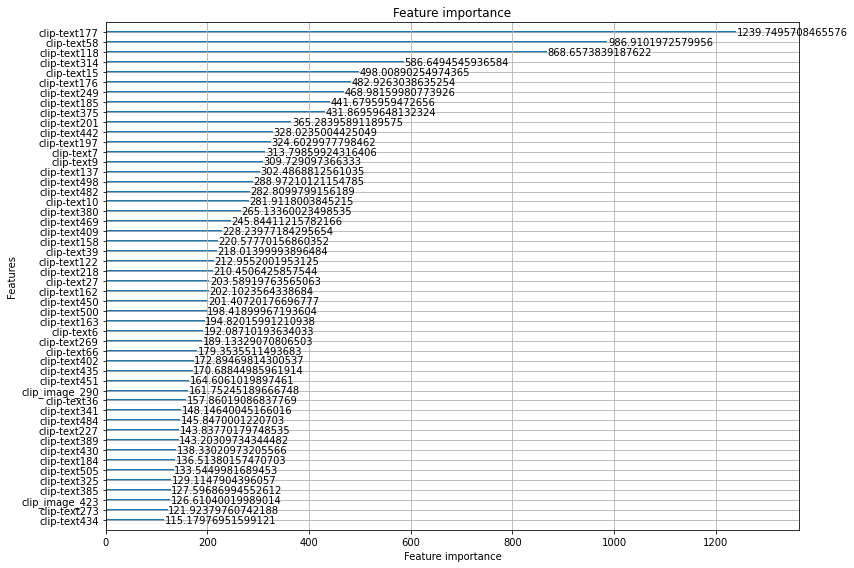

In [ ]:
# 特徴量の重要度を可視化。
lgb.plot_importance(lgb_clf, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [ ]:
# 評価指標はlog lossだが、accuracyも見てみる

val_pred = lgb_clf.predict(valid_x, num_iteration=lgb_clf.best_iteration)
val_pred_max = np.round(lgb_clf.predict(valid_x)).astype(int)  # クラスに分類
accuracy = sum(valid_y == val_pred_max) / len(valid_y)
print(accuracy)

0.5691968756258762


Text(0.5, 51.0, 'Predict')

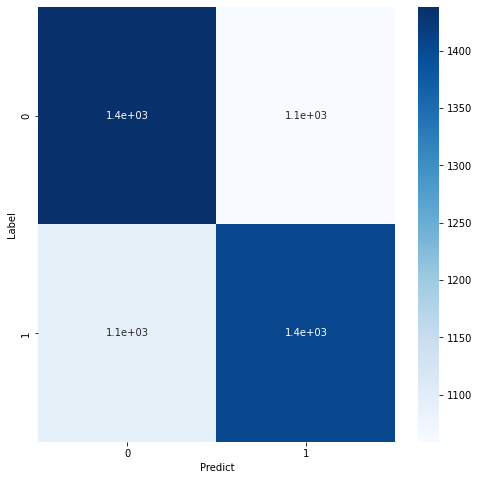

In [ ]:
_conf_options = {"normalize": None,}
_plot_options = {
        "cmap": "Blues",
        "annot": True
    }

conf = confusion_matrix(y_true=valid_y,
                        y_pred=val_pred_max,
                        **_conf_options)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf, ax=ax, **_plot_options)
ax.set_ylabel("Label")
ax.set_xlabel("Predict")

# Predict

In [ ]:
test_pred = lgb_clf.predict(test_x, num_iteration=lgb_clf.best_iteration)

In [ ]:
submission_df["is_laugh"] = test_pred
submission_df.head()

,id,is_laugh
0,rfdjcfsqq,0.592954
1,tsgqmfpef,0.352611
2,owjcthkz2,0.436790
3,rvgaocjyy,0.492911
4,uxtwu5i69,0.725688


In [ ]:
submission_df.to_csv(('/content/drive/MyDrive/nishika/sub.csv'), index=False)

実際に提出して、スコアを確認してみましょう。  精度向上に向けて様々なアイディアがあるかと思いますので、ぜひいろいろとトライしていただければと思います！

- 異なる学習済みモデルでの特徴量化
- 画像の状況とボケての文章との解離具合を測定する
- 説明文口調とセリフ口調の分類をしてみる。
- 画像に何が写っているかを検出し、特徴量に加えてみる（人が写っている。動物が写っている）
